In [ ]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

import matplotlib.pyplot as plt

# Task1: Acquire the data

In [ ]:
# Set up data transformations (including normalization)
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for CIFAR-10
])

# Load the CIFAR-10 dataset
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def flatten_data(dataset):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    return images.view(images.size(0), -1), labels

cifar_train_images, cifar_train_labels = flatten_data(cifar_trainset)
cifar_test_images, cifar_test_labels = flatten_data(cifar_testset)

In [ ]:
# Convert torch tensors to numpy
X_train = cifar_train_images.numpy()
X_test = cifar_test_images.numpy()

y_train_labels = cifar_train_labels.numpy().astype(int)
y_test_labels = cifar_test_labels.numpy().astype(int)

# One-hot encoding of labels
y_train = np.eye(10)[y_train_labels]
y_test = np.eye(10)[y_test_labels]

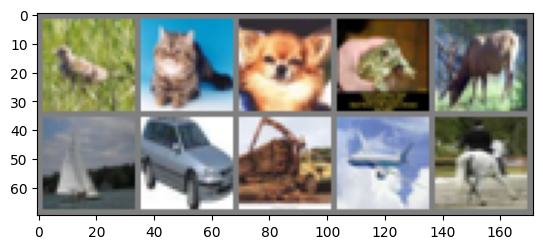

The classes are: 
 bird,   cat,   dog,  frog,  deer,  ship,   car, truck, plane, horse, 


In [ ]:
# Define a function to show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Trainloader definition as before
trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=4, shuffle=True, num_workers=2)

# Classes in CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Collect samples from each class
collected_classes = set()
collected_images = []
collected_labels = []

dataiter = iter(trainloader)
while len(collected_classes) < 10:
    images, labels = next(dataiter)
    for i in range(4):
        if labels[i].item() not in collected_classes:
            collected_classes.add(labels[i].item())
            collected_images.append(images[i])
            collected_labels.append(labels[i])
            if len(collected_classes) == 10:
                break

# Convert list of tensors to a single tensor
collected_images = torch.stack(collected_images)
collected_labels = torch.tensor(collected_labels)

# Show images in a grid of 5x2
imshow(torchvision.utils.make_grid(collected_images, nrow=5))


print("The classes are: ")
# Print labels
print(''.join('%5s, ' % classes[collected_labels[j]] for j in range(10)))


# Task 2: Implementations

In [ ]:
def evaluate_acc(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    return correct / total

### Class of MLP

In [ ]:
class MLP:
    def __init__(self, hidden_layers, activation_function='relu', initialization='gaussian',
                 l1_lambda=0.01, l2_lambda=0):
        self.hidden_layers = hidden_layers
        self.activation_function = activation_function
        self.weights = []
        self.biases = []
        self.activations = []

        # Regularization parameters
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

        # Weight and Bias Initialization
        input_size = 32*32*3
        for units in hidden_layers:
            self.weights.append(self.initialize_weights(input_size, units, initialization))
            self.biases.append(np.zeros((1, units)))
            input_size = units
        self.weights.append(self.initialize_weights(input_size, 10, initialization))
        self.biases.append(np.zeros((1, 10)))


    # New method for weight initialization
    def initialize_weights(self, size_in, size_out, method):
        if method == 'uniform':
            return np.zeros((size_in, size_out))
        elif method == 'xavier':
            return np.random.randn(size_in, size_out) / np.sqrt(size_in)
        elif method == 'gaussian':
            return np.random.randn(size_in, size_out)
        else:
            raise ValueError(f"Unknown initialization method: {method}")

    def activation(self, z):
        if self.activation_function == 'relu':
            return np.maximum(0, z)
        elif self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        elif self.activation_function == 'tanh':
            return np.tanh(z)
        else:
            raise ValueError(f"Unknown activation function: {self.activation_function}")

    def activation_derivative(self, z):
        if self.activation_function == 'relu':
            return (z > 0).astype(float)
        elif self.activation_function == 'sigmoid':
            sigmoid_val = self.activation(z)
            return sigmoid_val * (1 - sigmoid_val)
        elif self.activation_function == 'tanh':
            tanh_val = self.activation(z)
            return 1.0 - tanh_val**2
        else:
            raise ValueError(f"Unknown activation function: {self.activation_function}")

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def compute_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]
        log_probs = -np.log(y_pred[np.arange(n_samples), y_true.argmax(axis=1)])
        cross_entropy = np.sum(log_probs) / n_samples

        # Regularization
        l1_loss = self.l1_lambda * sum([np.sum(np.abs(w)) for w in self.weights])
        l2_loss = self.l2_lambda * sum([np.sum(w**2) for w in self.weights])

        return cross_entropy + l1_loss + l2_loss

    def forward_pass(self, X):
        self.activations = [X]
        for i in range(len(self.hidden_layers)):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.activations.append(self.activation(z))
        z_out = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.activations.append(self.softmax(z_out))
        return self.activations[-1]

    def backward_pass(self, X, y, learning_rate):
        m = X.shape[0]
        dz = self.activations[-1] - y
        for i in reversed(range(len(self.weights))):
            dw = np.dot(self.activations[i].T, dz) / m
            db = np.sum(dz, axis=0) / m

            # Incorporate L1 and L2 regularization into the weight updates
            dw += self.l1_lambda * np.sign(self.weights[i]) / m + self.l2_lambda * self.weights[i] / m

            if i != 0:
                dz = np.dot(dz, self.weights[i].T) * self.activation_derivative(self.activations[i])

            self.weights[i] -= learning_rate * dw
            self.biases[i] -= learning_rate * db

    def fit(self, X, y, learning_rate=0.001, epochs=10, batch_size=64):
        for epoch in range(epochs):
            idx = np.random.permutation(X.shape[0])
            X_shuffled = X[idx]
            y_shuffled = y[idx]
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                self.forward_pass(X_batch)
                self.backward_pass(X_batch, y_batch, learning_rate)

    def predict(self, X):
        predictions = self.forward_pass(X)
        return np.argmax(predictions, axis=1)


### Class of CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Task 3: Implementations

### 3.7 Implement MLP and CNN

First try CNN:

In [ ]:
cnn = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=32, shuffle=True)

for epoch in range(10):
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


In [ ]:
# Create a test dataloader
testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=32, shuffle=False)

# Function to evaluate accuracy
def evaluate_accuracy(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Compute test accuracy
test_accuracy = evaluate_accuracy(cnn, testloader)
print(f"Test Accuracy on CIFAR-10: {test_accuracy:.4f}")


Test Accuracy on CIFAR-10: 0.6961


In [ ]:
cnn.eval()


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Then try MLP:

In [ ]:
mlp = MLP(hidden_layers=[512, 512], activation_function="relu")
mlp.fit(X_train, y_train, learning_rate=0.001, epochs=10)

In [ ]:
# Predict and evaluate
mlp_y_pred_train = mlp.predict(X_train)
mlp_y_pred_test = mlp.predict(X_test)

print("Training Accuracy:", evaluate_acc(y_train_labels, mlp_y_pred_train))
print("Test Accuracy:", evaluate_acc(y_test_labels, mlp_y_pred_test))

Training Accuracy: 0.25936
Test Accuracy: 0.2315


### 3.8 Implementations with growing momentum factor

In [ ]:
def evaluate_model(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy


In [ ]:
# List of configurations
configs = [
    {"optimizer": "SGD", "momentum": 0, "lr": 0.001},
    {"optimizer": "SGD", "momentum": 0.2, "lr": 0.001},
    {"optimizer": "SGD", "momentum": 0.4, "lr": 0.001},
    {"optimizer": "SGD", "momentum": 0.6, "lr": 0.001},
    {"optimizer": "SGD", "momentum": 0.9, "lr": 0.001},
    {"optimizer": "Adam", "lr": 0.001}
]

results = {}
losses = {}

testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=32, shuffle=False)

# Train and evaluate for each configuration
for config in configs:
    cnn = CNN()
    epoch_losses = []

    if config["optimizer"] == "SGD":
        optimizer = optim.SGD(cnn.parameters(), lr=config["lr"], momentum=config["momentum"])
    elif config["optimizer"] == "Adam":
        optimizer = optim.Adam(cnn.parameters(), lr=config["lr"])

    # Training loop
    for epoch in range(10):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_losses.append(running_loss / len(trainloader))

    # Evaluate test accuracy
    test_accuracy = evaluate_model(cnn, testloader)

    # Store results
    key = f"{config['optimizer']} (lr={config['lr']})"
    if "momentum" in config:
        key += f", momentum={config['momentum']}"
    results[key] = test_accuracy

    # Store epoch losses
    key = f"{config['optimizer']} (lr={config['lr']})"
    if "momentum" in config:
        key += f", momentum={config['momentum']}"
    losses[key] = epoch_losses

# Print out results
for key, accuracy in results.items():
    print(f"{key}: Test Accuracy = {accuracy:.4f}")


SGD (lr=0.001), momentum=0: Test Accuracy = 0.4565
SGD (lr=0.001), momentum=0.2: Test Accuracy = 0.4948
SGD (lr=0.001), momentum=0.4: Test Accuracy = 0.5251
SGD (lr=0.001), momentum=0.6: Test Accuracy = 0.5680
SGD (lr=0.001), momentum=0.9: Test Accuracy = 0.6990
Adam (lr=0.001): Test Accuracy = 0.7043


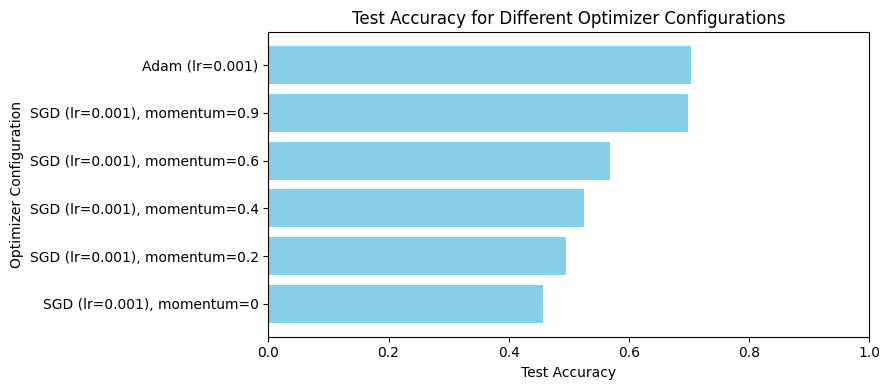

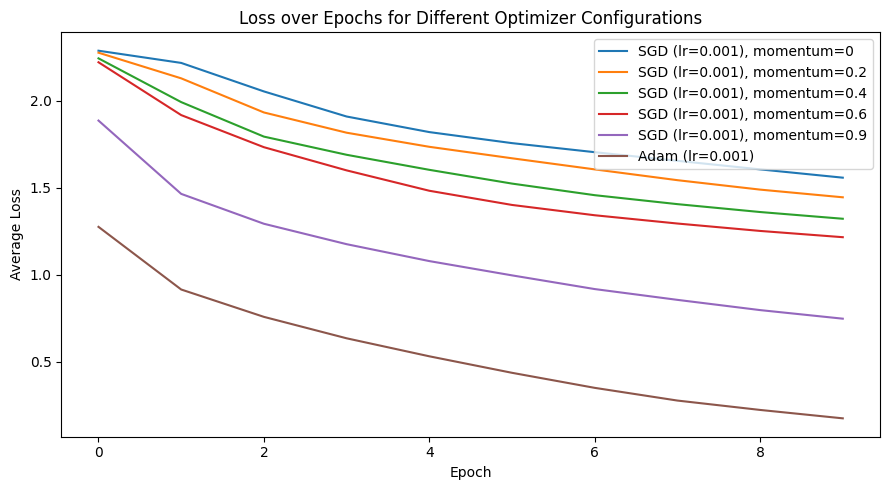

In [ ]:
# Plot Test Accuracy
plt.figure(figsize=(9, 4))
sorted_keys = sorted(results, key=results.get, reverse=True)
sorted_accuracies = [results[key] for key in sorted_keys]
plt.barh(sorted_keys, sorted_accuracies, color='skyblue')
plt.xlabel('Test Accuracy')
plt.ylabel('Optimizer Configuration')
plt.title('Test Accuracy for Different Optimizer Configurations')
plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Plot Loss over Epochs for each configuration
plt.figure(figsize=(9, 5))
for key, loss in losses.items():
    plt.plot(loss, label=key)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss over Epochs for Different Optimizer Configurations')
plt.legend()
plt.tight_layout()
plt.show()

### 3.9 Compare with pre-trained ResNet

### Load the pre-trained ResNet

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet50 model
resnet50 = models.resnet50(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze all layers
for param in resnet50.parameters():
    param.requires_grad = False


In [ ]:
num_ftrs = resnet50.fc.in_features

# Remove all fully connected layers and add two new ones
resnet50.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),  # First fully connected layer
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10),  # Second fully connected layer
).to(device)


In [ ]:
# Resize images to fit ResNet's input size
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Implementations

#### ResNet50

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)  # Only optimize the fc layers

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    resnet50.train()

    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

print("Finished Training!")


In [ ]:
def evaluate_accuracy(model, dataloader, device):
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()  # Set the model back to training mode
    return correct / total


#### ResNet18

In [ ]:
# Load the CIFAR-10 dataset
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet18 was originally trained on 224x224 images
    transforms.ToTensor(),
    normalize
])

# Load the CIFAR-10 dataset with transformations
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                  download=True, transform=transform)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                 download=True, transform=transform)

trainloader = data_utils.DataLoader(cifar_trainset, batch_size=32,
                              shuffle=True, num_workers=2)
testloader = data_utils.DataLoader(cifar_testset, batch_size=32,
                             shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 59625642.63it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained ResNet18
resnet18 = torchvision.models.resnet18(pretrained=True)

# Freeze all the convolutional layers
for param in resnet18.parameters():
    param.requires_grad = False

# Remove the fully connected layer and add new ones
num_features = resnet18.fc.in_features

resnet18.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
).to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.001)

Epoch 1, Loss: 0.7510065092482936
Epoch 2, Loss: 0.7088433990322925
Finished Training


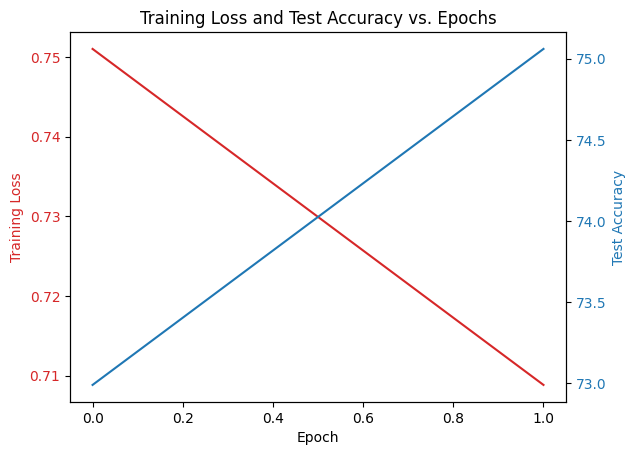

In [ ]:
# Additional function to evaluate model accuracy on test set
def evaluate_accuracy(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

# Initialize lists to store losses and accuracies
training_losses = []
test_accuracies = []

# Train the model and store metrics
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}")

    # Append to our metric lists
    training_losses.append(running_loss / len(trainloader))
    test_accuracies.append(evaluate_accuracy(resnet18, testloader))
    running_loss = 0.0

print('Finished Training')

# Plot the training loss and test accuracy
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(training_losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Test Accuracy', color=color)
ax2.plot(test_accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Training Loss and Test Accuracy vs. Epochs")
plt.show()
